In [175]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import nltk     
import re
import string
import spacy
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import graphviz 
from sklearn import tree
from sklearn import metrics
from wordcloud import WordCloud
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path

DATA_DIR = os.path.join( '..', 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')



In [176]:

file_path=os.path.join(RAW_DATA_DIR,"SMSSpamCollection")

# Utiliza \t como delimitador
sms = pd.read_csv(file_path, sep="\t", header=None, names=["Label", "SMS"])
sms.head()


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [177]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [178]:
sms.shape

(5572, 2)

In [179]:
sms.Label.value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [180]:
#value counts as percentage
sms.Label.value_counts(normalize=True)


Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

In [181]:
#check for missing values
sms.isnull().sum()

Label    0
SMS      0
dtype: int64

In [182]:
sms.duplicated(subset="SMS",keep="first").sum()



403

In [183]:
sms[sms.duplicated(subset="SMS",keep=False)].sort_values(by="SMS")

,Label,SMS
505,spam,+123 Congratulations - in this week's competit...
2124,spam,+123 Congratulations - in this week's competit...
2344,ham,1) Go to write msg 2) Put on Dictionary mode 3...
1373,ham,1) Go to write msg 2) Put on Dictionary mode 3...
2163,ham,1) Go to write msg 2) Put on Dictionary mode 3...
...,...,...
1381,ham,i dnt wnt to tlk wid u
1412,ham,somewhere out there beneath the pale moon ligh...
4004,ham,somewhere out there beneath the pale moon ligh...
2389,ham,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...


In [184]:


# Assuming 'sms' is your DataFrame
sms = sms[~(sms.duplicated(subset=['SMS']) & (sms['Label'] == 'ham'))].reset_index(drop=True)

# Print the shape of the resulting DataFrame
print(sms.shape)


(5263, 2)


In [185]:
sms['lenght'] = sms['SMS'].apply(len)

In [186]:
sms['Label'] = sms['Label'].map({'ham': 0, 'spam': 1})
sms.head()

,Label,SMS,lenght
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [187]:
sms['SMS'] = sms['SMS'].str.lower()

In [188]:
sms['SMS'] = sms['SMS'].astype(str)

In [189]:

def transformations(data):
    if data == "NA":
        return "NA"
    else:
        data = re.sub(r'\b(u)\b', 'you', data)
        data = re.sub(r'\b(2)\b', 'to', data)
        data = re.sub(r'\b(i\' m)\b', 'i am', data)
        data = re.sub(r'\b(cant)\b', 'can not', data)
        data = re.sub(r'\b(thats)\b', 'that is', data)
        data = re.sub(r'\b(im)\b', 'i am', data)
        data = re.sub(r'\b(ill)\b', 'i will', data)
        data = re.sub(r'\b(ur)\b', 'your', data)
        data = re.sub(r'\b(4)\b', 'for', data)
        data = re.sub(r'\b(n)\b', 'no', data)
        data = re.sub(r'\b(i\'ll)\b', 'i will', data)
        data = re.sub(r'\b(ü)\b', 'you', data)
        data = re.sub(r'\b(&)\b', 'and', data)
        data = re.sub(r'\b(txt)\b', 'text', data)
        data = re.sub(r'\b(1)\b', 'one', data)
        data = re.sub(r'\b(po)\b', 'purchase order', data)
        data = re.sub(r'\b(dont)\b', 'do not', data)
        data = re.sub(r'\b(don\'t)\b', 'do not', data)
        data = re.sub(r'\b(lor)\b', 'lot', data)
        data = re.sub(r'\b(msg)\b', 'message', data)
        data = re.sub(r'\b(wat)\b', 'what', data)
        data = re.sub(r'\b(na)\b', 'not available', data)
        data = re.sub(r'\b(pls)\b', 'please', data)
        data = re.sub(r'\b(wkly)\b', 'weekly', data)
        data = re.sub(r'\b(i\'d)\b', 'i would', data)
        data = re.sub(r'\b(2nd)\b', 'second', data)
        data = re.sub(r'\b(usf)\b', 'university of south florida', data)
        data = re.sub(r'\b(hor)\b', 'hour', data)
        data = re.sub(r'\b(fr)\b', 'for', data)
        data = re.sub(r'\b(gt)\b', 'get', data)
        data = re.sub(r'\b(lt)\b', 'let', data)
        data = re.sub(r'\b(comp)\b', 'composition', data)
        data = re.sub(r'\b(go)\b', 'gone', data)
        data = re.sub(r'\b(wan)\b', 'want', data)
        data = re.sub(r'\b(mob)\b', 'mobile', data)
        data = re.sub(r'\b(\'s)\b', 'is', data)
        data = re.sub(r'\b(m)\b', 'i am', data)
        data = re.sub(r'\b(ll)\b', 'will', data)
        data = re.sub(r'\b(its)\b', 'it is', data)
        data = re.sub(r'\b(itis)\b', 'it is', data)
        data = re.sub(r'\b(i\'i)\b', 'i', data)
        data = re.sub(r'\b(cos)\b', 'because', data)
        return data

nlp = spacy.load('en_core_web_sm')
import spacy

def word_tokenize(text, language='en_core_web_sm'):
    """
    Tokeniza un texto en inglés utilizando spaCy.

    Parámetros:
    - text: Texto a ser tokenizado.
    - language: Modelo de lenguaje de spaCy a utilizar (por defecto, 'en_core_web_sm').

    Retorna:
    - Lista de tokens.
    """
    nlp = spacy.load(language)
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

# Inicializar el lematizador de spaCy
nlp = spacy.load('en_core_web_sm')

# Supongamos que ya tienes el DataFrame 'sms' con una columna 'Tokens' que contiene listas de palabras
# sms['Tokens'] = ...

# Definir la función de lematización con spaCy
def lemmatize_text(word_list):
    text = ' '.join(word_list)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

from nltk.corpus import stopwords

# Descargar la lista de stopwords en inglés si no lo has hecho antes
nltk.download('stopwords')

# Definir la lista de stopwords en inglés
stop_words = set(stopwords.words('english'))

def remove_stopwords(lemmas):
    """
    Elimina las stopwords de una lista de lemas.

    Parámetros:
    - lemas: Lista de lemas.

    Retorna:
    - Lista de lemas sin stopwords.
    """
    filtered_lemmas = [lemma for lemma in lemmas if lemma.lower() not in stop_words]
    return filtered_lemmas


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [190]:
sms['SMS'] = sms['SMS'].apply(transformations)
print(sms)

      Label                                                SMS  lenght
0         0  gone until jurong point, crazy.. available onl...     111
1         0                    ok lar... joking wif you oni...      29
2         1  free entry in to a weekly composition to win f...     155
3         0  you dun say so early hour... you c already the...      49
4         0  nah i do not think he goes to university of so...      61
...     ...                                                ...     ...
5258      1  this is the second time we have tried to conta...     160
5259      0            will you b going to esplanade for home?      36
5260      0  pity, * was in mood for that. so...any other s...      57
5261      0  the guy did some bitching but i acted like i w...     125
5262      0                     rofl. it is true to it is name      26

[5263 rows x 3 columns]


In [191]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import nltk

In [192]:
sms['Tokens'] = sms['SMS'].apply(lambda text: word_tokenize(text))

# Visualizar el DataFrame resultante
print(sms.head())


   Label                                                SMS  lenght  \
0      0  gone until jurong point, crazy.. available onl...     111   
1      0                    ok lar... joking wif you oni...      29   
2      1  free entry in to a weekly composition to win f...     155   
3      0  you dun say so early hour... you c already the...      49   
4      0  nah i do not think he goes to university of so...      61   

                                              Tokens  
0  [gone, until, jurong, point, ,, crazy, .., ava...  
1         [ok, lar, ..., joking, wif, you, oni, ...]  
2  [free, entry, in, to, a, weekly, composition, ...  
3  [you, dun, say, so, early, hour, ..., you, c, ...  
4  [nah, i, do, not, think, he, goes, to, univers...  


In [193]:
import pandas as pd
import spacy


# Aplicar la lematización a la columna 'Tokens' y almacenar los resultados en una nueva columna 'lemmatized_tokens'
sms['lemmatized_text'] = sms['Tokens'].apply(lemmatize_text)

# Visualizar el DataFrame resultante
print(sms[['Tokens', 'lemmatized_text']])


                                                 Tokens  \
0     [gone, until, jurong, point, ,, crazy, .., ava...   
1            [ok, lar, ..., joking, wif, you, oni, ...]   
2     [free, entry, in, to, a, weekly, composition, ...   
3     [you, dun, say, so, early, hour, ..., you, c, ...   
4     [nah, i, do, not, think, he, goes, to, univers...   
...                                                 ...   
5258  [this, is, the, second, time, we, have, tried,...   
5259  [will, you, b, going, to, esplanade, for, home...   
5260  [pity, ,, *, was, in, mood, for, that, ., so, ...   
5261  [the, guy, did, some, bitching, but, i, acted,...   
5262          [rofl, ., it, is, true, to, it, is, name]   

                                        lemmatized_text  
0     [go, until, jurong, point, ,, crazy, .., avail...  
1              [ok, lar, ..., joke, wif, you, oni, ...]  
2     [free, entry, in, to, a, weekly, composition, ...  
3     [you, dun, say, so, early, hour, ..., you, c, ...  
4

In [194]:
# Aplicar la eliminación de stopwords a la columna 'lemmatized_text' y almacenar los resultados en una nueva columna 'lemmatized_text_without_stopwords'
sms['SMS_without_stopwords'] = sms['lemmatized_text'].apply(remove_stopwords)

# Visualizar el DataFrame resultante
print(sms[['lemmatized_text', 'SMS_without_stopwords']])

                                        lemmatized_text  \
0     [go, until, jurong, point, ,, crazy, .., avail...   
1              [ok, lar, ..., joke, wif, you, oni, ...]   
2     [free, entry, in, to, a, weekly, composition, ...   
3     [you, dun, say, so, early, hour, ..., you, c, ...   
4     [nah, I, do, not, think, he, go, to, universit...   
...                                                 ...   
5258  [this, be, the, second, time, we, have, try, t...   
5259    [will, you, b, go, to, esplanade, for, home, ?]   
5260  [pity, ,, *, be, in, mood, for, that, ., so, ....   
5261  [the, guy, do, some, bitching, but, I, act, li...   
5262          [rofl, ., it, be, true, to, it, be, name]   

                                  SMS_without_stopwords  
0     [go, jurong, point, ,, crazy, .., available, b...  
1                   [ok, lar, ..., joke, wif, oni, ...]  
2     [free, entry, weekly, composition, win, fa, cu...  
3     [dun, say, early, hour, ..., c, already, say, ...  
4

In [195]:
# Palabras a eliminar
words_to_remove = ["&let;#&get;", "&amp;"]

# Reemplazar las palabras en la columna 'SMS'
sms['SMS'] = sms['SMS'].replace(words_to_remove, '', regex=True)

# Visualizar el DataFrame resultante
print(sms)

      Label                                                SMS  lenght  \
0         0  gone until jurong point, crazy.. available onl...     111   
1         0                    ok lar... joking wif you oni...      29   
2         1  free entry in to a weekly composition to win f...     155   
3         0  you dun say so early hour... you c already the...      49   
4         0  nah i do not think he goes to university of so...      61   
...     ...                                                ...     ...   
5258      1  this is the second time we have tried to conta...     160   
5259      0            will you b going to esplanade for home?      36   
5260      0  pity, * was in mood for that. so...any other s...      57   
5261      0  the guy did some bitching but i acted like i w...     125   
5262      0                     rofl. it is true to it is name      26   

                                                 Tokens  \
0     [gone, until, jurong, point, ,, crazy, .., ava

In [196]:
sms.head()

,Label,SMS,lenght,Tokens,lemmatized_text,SMS_without_stopwords
0,0,"gone until jurong point, crazy.. available onl...",111,"[gone, until, jurong, point, ,, crazy, .., ava...","[go, until, jurong, point, ,, crazy, .., avail...","[go, jurong, point, ,, crazy, .., available, b..."
1,0,ok lar... joking wif you oni...,29,"[ok, lar, ..., joking, wif, you, oni, ...]","[ok, lar, ..., joke, wif, you, oni, ...]","[ok, lar, ..., joke, wif, oni, ...]"
2,1,free entry in to a weekly composition to win f...,155,"[free, entry, in, to, a, weekly, composition, ...","[free, entry, in, to, a, weekly, composition, ...","[free, entry, weekly, composition, win, fa, cu..."
3,0,you dun say so early hour... you c already the...,49,"[you, dun, say, so, early, hour, ..., you, c, ...","[you, dun, say, so, early, hour, ..., you, c, ...","[dun, say, early, hour, ..., c, already, say, ..."
4,0,nah i do not think he goes to university of so...,61,"[nah, i, do, not, think, he, goes, to, univers...","[nah, I, do, not, think, he, go, to, universit...","[nah, think, go, university, south, florida, ,..."


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


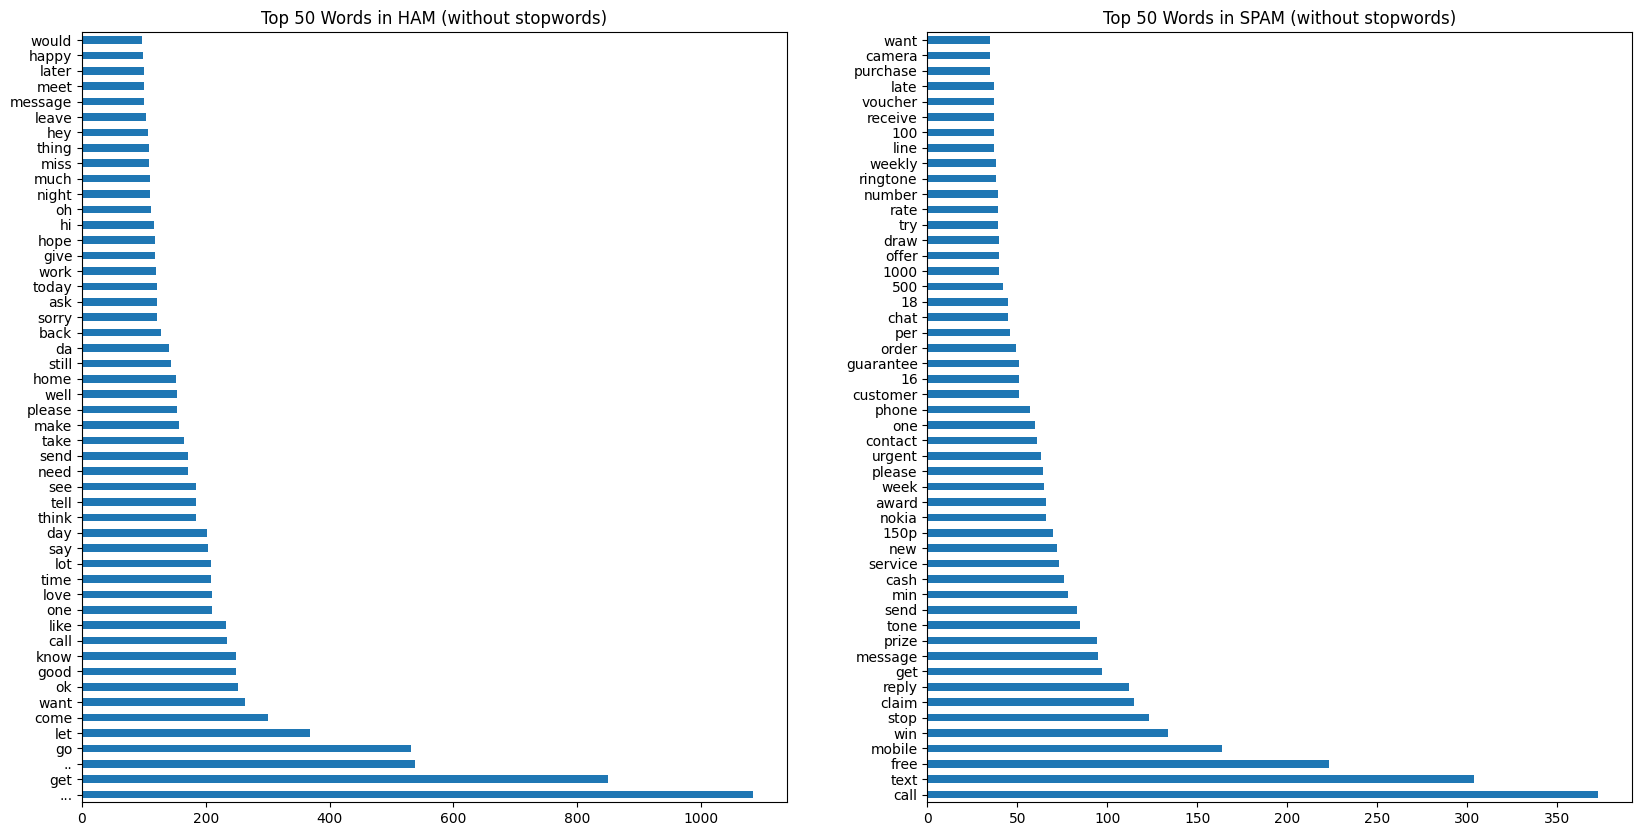

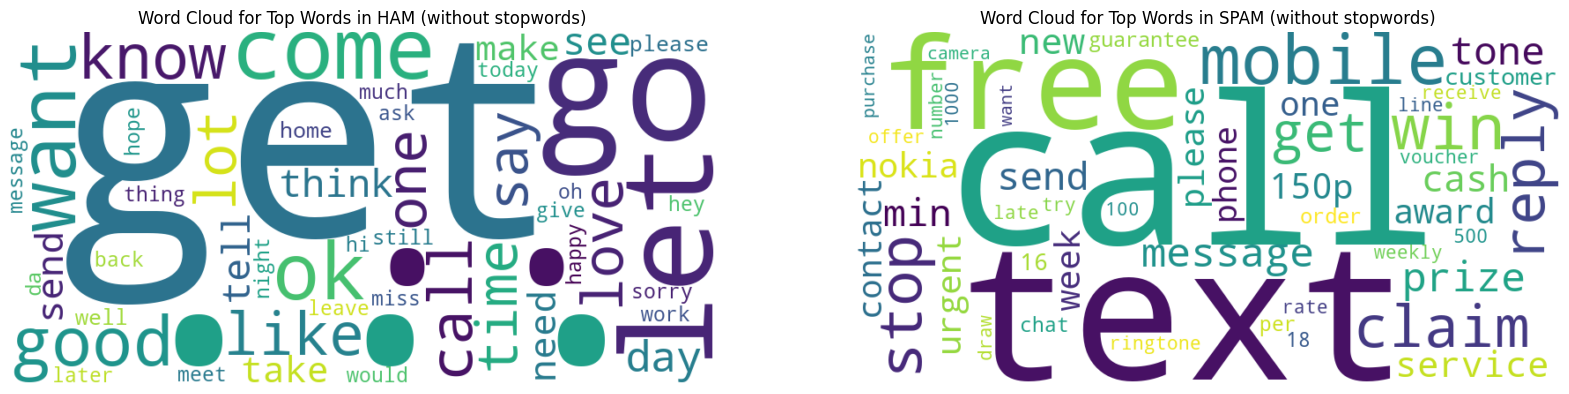

In [197]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
import nltk
import string

# Descargar stopwords si aún no están descargadas
nltk.download('stopwords')

# Suponiendo que tienes 'stop_words' definido
stop_words = set(stopwords.words('english'))

# Función para obtener las palabras principales excluyendo stopwords y palabras de un solo carácter
def top_words(series, n=50):
    all_words = [word for sublist in series for word in sublist]  # Aplanar la lista de listas
    word_counts = pd.Series(all_words).value_counts()
    
    # Excluir stopwords y palabras de un solo carácter
    word_counts = word_counts[~word_counts.index.isin(stop_words) & (word_counts.index.str.len() > 1)]
    
    return word_counts.head(n)

# Gráfico de barras original
grouped = sms.groupby('Label')

ham_top_words = top_words(grouped.get_group(0)['SMS_without_stopwords'])
spam_top_words = top_words(grouped.get_group(1)['SMS_without_stopwords'])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ham_top_words.plot(kind='barh', ax=axes[0], title='Top 50 Words in HAM (without stopwords)')
spam_top_words.plot(kind='barh', ax=axes[1], title='Top 50 Words in SPAM (without stopwords)')

plt.show()

# Nubes de palabras basadas en las palabras principales sin stopwords
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ham_top_words)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(spam_top_words)

# Mostrar nubes de palabras
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(ham_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud for Top Words in HAM (without stopwords)')
axes[0].axis('off')

axes[1].imshow(spam_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud for Top Words in SPAM (without stopwords)')
axes[1].axis('off')

plt.show()



C:\Users\lunai\AppData\Local\Temp\ipykernel_19544\3938901792.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(v, i, f'{v} ({ham_percentages[i]:.2f}%)', color='black', va='center')
C:\Users\lunai\AppData\Local\Temp\ipykernel_19544\3938901792.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].text(v, i, f'{v} ({spam_percentages[i]:.2f}%)', color='black', va='center')


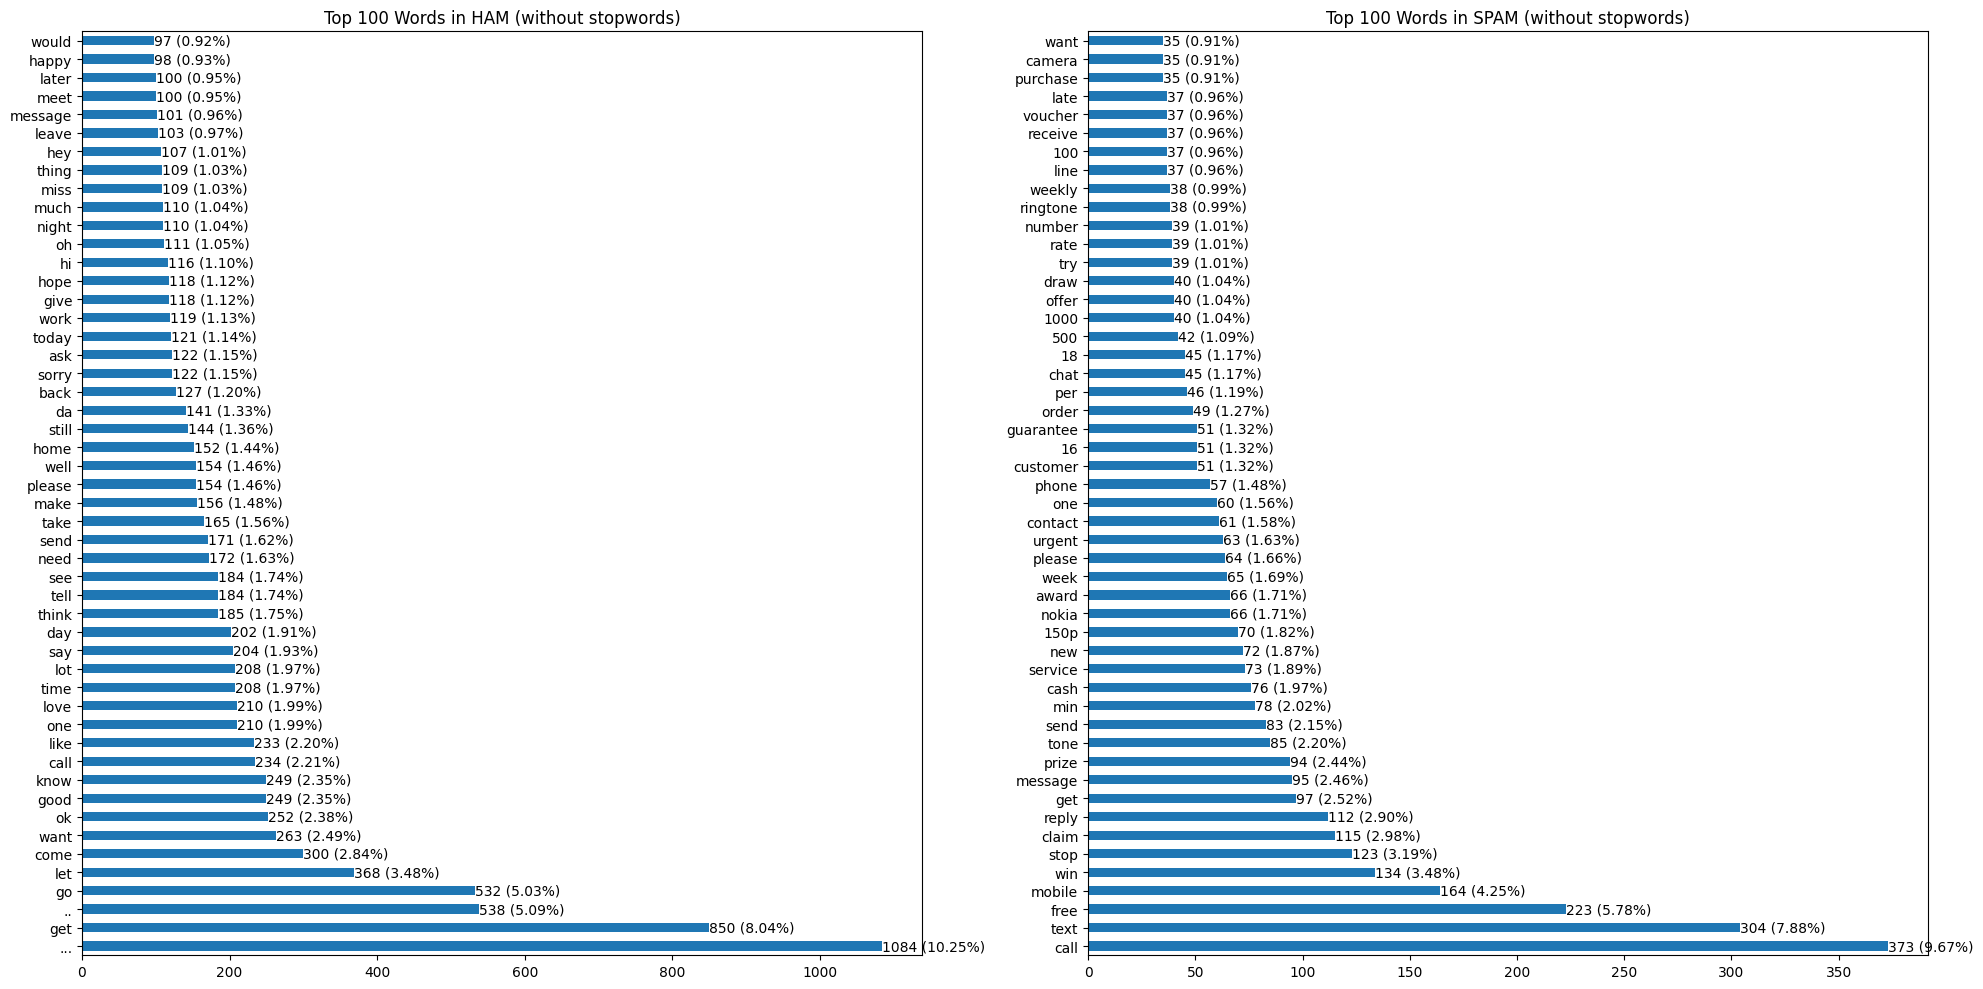

In [198]:
# Obtener el total de palabras en cada grupo (SPAM y HAM)
total_ham_words = ham_top_words.sum()
total_spam_words = spam_top_words.sum()

# Calcular los porcentajes de cada palabra en relación con el total de palabras en cada grupo
ham_percentages = (ham_top_words / total_ham_words) * 100
spam_percentages = (spam_top_words / total_spam_words) * 100

# Realizar el gráfico con los porcentajes
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico para HAM con porcentajes
ham_top_words.plot(kind='barh', ax=axes[0], title='Top 100 Words in HAM (without stopwords)')
for i, v in enumerate(ham_top_words):
    axes[0].text(v, i, f'{v} ({ham_percentages[i]:.2f}%)', color='black', va='center')

# Gráfico para SPAM con porcentajes
spam_top_words.plot(kind='barh', ax=axes[1], title='Top 100 Words in SPAM (without stopwords)')
for i, v in enumerate(spam_top_words):
    axes[1].text(v, i, f'{v} ({spam_percentages[i]:.2f}%)', color='black', va='center')

plt.tight_layout()
plt.show()

In [199]:
# Supongamos que ya tienes las variables ham_top_words, spam_top_words, total_ham_words y total_spam_words definidas

# Obtener listas de palabras para HAM y SPAM y eliminar stopwords
stop_words = set(stopwords.words('english'))

ham_words = set(ham_top_words.index) - stop_words
spam_words = set(spam_top_words.index) - stop_words

# Encontrar palabras que están en ambas listas
common_words = ham_words.intersection(spam_words)

# Calcular porcentaje de palabras comunes en relación con HAM y SPAM
common_words_percentage_ham = sum(ham_top_words[word] for word in common_words) / total_ham_words * 100
common_words_percentage_spam = sum(spam_top_words[word] for word in common_words) / total_spam_words * 100

# Crear un DataFrame con las columnas de palabras de HAM, palabras de SPAM y diferencia con porcentaje
data = {
    'Word': list(common_words),
    'HAM Words Percentage': [ham_top_words[word] / total_ham_words * 100 for word in common_words],
    'SPAM Words Percentage': [spam_top_words[word] / total_spam_words * 100 for word in common_words],
}

df = pd.DataFrame(data)

# Agregar columna de diferencia porcentual
df['Diferencia_porcentual'] = df['HAM Words Percentage'] - df['SPAM Words Percentage']

# Ordenar el DataFrame por la columna de diferencia porcentual de mayor a menor, manteniendo las palabras como índices
df = df.set_index('Word').sort_values(by='Diferencia_porcentual', ascending=False)

# Imprimir el DataFrame
print(df)

         HAM Words Percentage  SPAM Words Percentage  Diferencia_porcentual
Word                                                                       
get                  8.038585               2.515560               5.523025
want                 2.487233               0.907676               1.579556
one                  1.986003               1.556017               0.429987
please               1.456402               1.659751              -0.203349
send                 1.617174               2.152490              -0.535315
message              0.955173               2.463693              -1.508520
call                 2.212975               9.673237              -7.460261


In [200]:
#crate a file in data proccessed with the dataset sms with all the changes in this notebook
file_path=os.path.join(PROCESSED_DATA_DIR,"sms.csv")
sms.to_csv(file_path,index=False)

